# Perceptron

Load iris dataset from UCI machine learning repository.

In [1]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, header=None, encoding="utf-8")
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


First 50 samples belong to *Iris-setosa* and the next 50 samples belong to *Iris-versicolor*. Column index 0 and 2 represent *SepalLengthCm* and *PetalLengthCm* respectively.

In [2]:
import numpy as np
x = df.iloc[0:100, [0, 2]].to_numpy(dtype="float32")
y = df.iloc[0:100, 4].to_numpy()
y = np.where(y == "Iris-setosa", -1, 1)

Display a scatter plot of iris dataset.

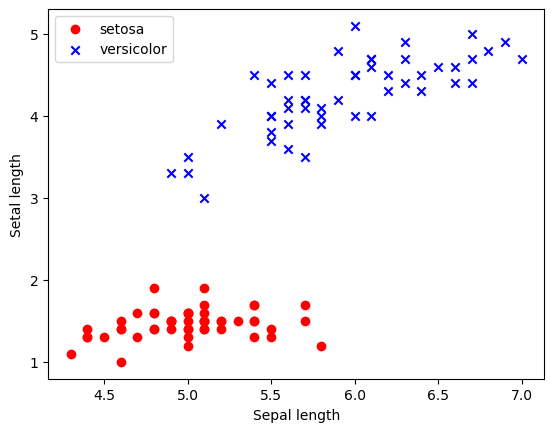

In [3]:
import matplotlib.pyplot as plt
plt.scatter(x[:50, 0], x[:50, 1], color="red", marker="o", label="setosa")
plt.scatter(x[50:100, 0], x[50:100, 1], color="blue", marker="x", label="versicolor")
plt.xlabel("Sepal length")
plt.ylabel("Setal length")
plt.legend(loc="upper left")
plt.show()

Define a **Perceptron** API using Python class.

In [4]:
class Perceptron(object):
    """
    lr: learning rate
    epochs: number of iterations
    random_state: seed
    """
    def __init__(self, lr=0.01, epochs=50, random_state=1):
        self.lr = lr
        self.epochs = epochs
        self.random_state = random_state
    
    """
    X: training dataset
    y: target values
    """
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        w_size = 1 + X.shape[1]
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=w_size)
        self.errors_ = []
        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.lr * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

Train a Perceptron model using iris dataset.

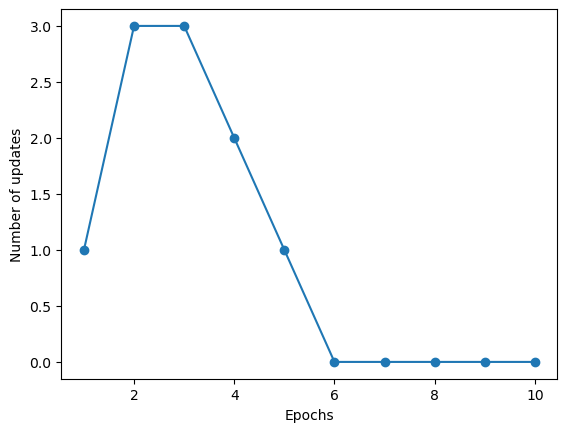

In [5]:
ppn = Perceptron(lr=0.1, epochs=10)
ppn.fit(x, y)
plt.plot(range(1, len(ppn.errors_)+1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

Visualize the decision boundary of iris dataset.

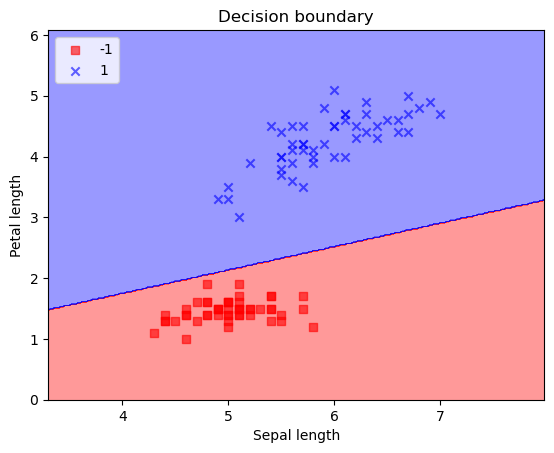

In [6]:
import utils
fig, ax = plt.subplots()
utils.plot_decision_boundary(ax, x, y, classifier=ppn)
plt.title("Decision boundary")
plt.xlabel("Sepal length")
plt.ylabel("Petal length")
plt.legend(loc="upper left")
plt.show()

# Adaptive Linear Neuron

Define an **Adaline Gradient Descent** API using Python class.

In [7]:
class AdalineGD(object):
    """
    lr: learning rate
    epochs: number of iterations
    random_state: seed
    """
    def __init__(self, lr=0.01, epochs=50, random_state=1):
        self.lr = lr
        self.epochs = epochs
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        w_size = 1 + X.shape[1]
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=w_size)
        self.cost_ = []
        for _ in range(self.epochs):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.lr * X.T.dot(errors)
            self.w_[0] += self.lr * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X 
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

Train an AdalineGD model using scaled iris dataset.

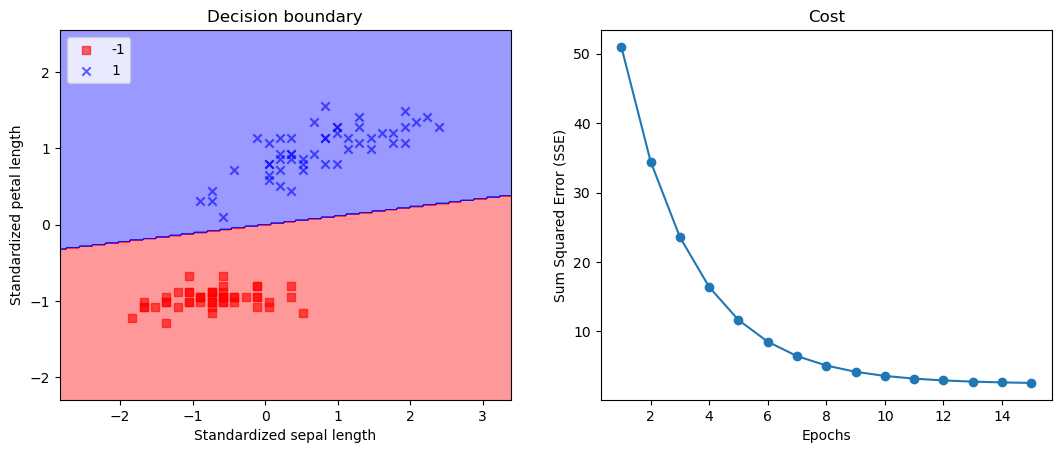

In [8]:
# feature standardization
x_std = np.copy(x)
x_std[:, 0] = (x[:, 0] - x[:, 0].mean()) / x[:, 0].std()
x_std[:, 1] = (x[:, 1] - x[:, 1].mean()) / x[:, 1].std()
ada = AdalineGD(lr=0.01, epochs=15)
ada.fit(x_std, y)
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))
# visualize decision boundary
utils.plot_decision_boundary(axs[0], x_std, y, classifier=ada)
axs[0].set_title("Decision boundary")
axs[0].set_xlabel("Standardized sepal length")
axs[0].set_ylabel("Standardized petal length")
axs[0].legend(loc="upper left")
# visualize decreasing cost
axs[1].plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
axs[1].set_title("Cost")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Sum Squared Error (SSE)")
plt.show()

# AdalineSGD

Create an **AdalineSGD** API using Python class. SGD stands for stochastic gradient descent method which updates weights based on each single sample instead of using the entire dataset.

In [9]:
class AdalineSGD(object):
    """
    lr: learning rate
    epochs: number of iterations
    shuffle: shuffle the dataset
    random_state: seed
    """
    def __init__(self, lr=0.01, epochs=50, shuffle=True, random_state=1):
        self.lr = lr
        self.epochs = epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.w_initialized = False

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for _ in range(self.epochs):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.lr * xi.dot(error)
        self.w_[0] += self.lr * error
        cost = 0.5 * (error**2)
        return cost

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

Train an AdalineSGD model.

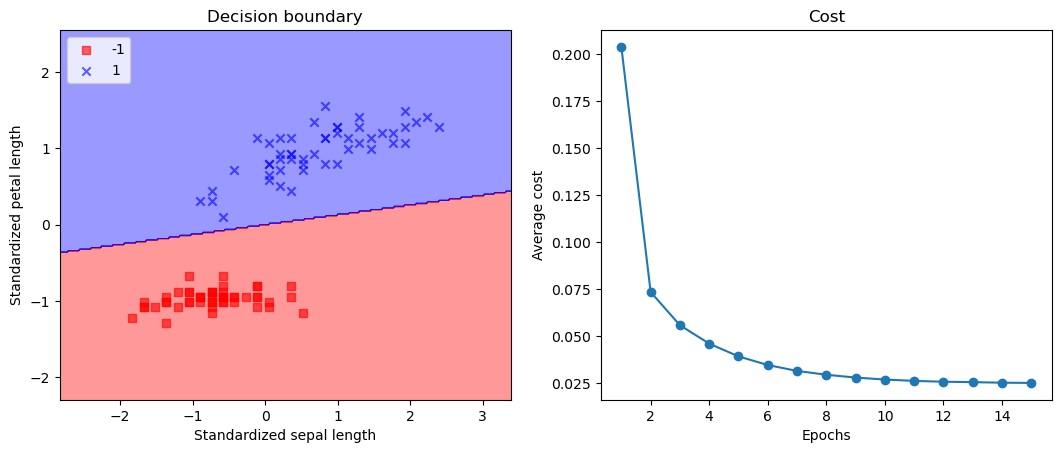

In [10]:
ada = AdalineSGD(lr=0.01, epochs=15)
ada.fit(x_std, y)
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))
# visualize decision boundary
utils.plot_decision_boundary(axs[0], x_std, y, classifier=ada)
axs[0].set_title("Decision boundary")
axs[0].set_xlabel("Standardized sepal length")
axs[0].set_ylabel("Standardized petal length")
axs[0].legend(loc="upper left")
# visualize decreasing cost
axs[1].plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
axs[1].set_title('Cost')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Average cost')
plt.show()

Compare above two cost plots, AdalineSGD model is much faster than AdalineGD in terms of the speed of cost convergence (i.e. find the global minimum of the cost function). That is because AdalineSGD frequently updates the weights than AdalineGD method (each single sample vs. the entire dataset).